# Pruning / LTH (CIFAR-100)

In [1]:
import copy
import json
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchinfo import summary
from torchvision import transforms
from tqdm import tqdm

In [2]:
drive = None
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
path = "./"

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
path = path if drive is None else "/content/drive/MyDrive/self-learn/pruning"

In [5]:
sys.path.append(path)

In [6]:
from constants import *
from utils import set_seed, train_data, val_data, \
                    train_loader, val_loader, fine_labels

set_seed()

Files already downloaded and verified
Files already downloaded and verified


In [7]:
MODEL_NAME = (
    f"CNN_CIFAR_100_PRUNE_PCT_{PRUNE_PCT}"
)
print("Model Name:", MODEL_NAME)

Model Name: CNN_CIFAR_100_PRUNE_PCT_0


# Data

In [8]:
# # should be (BATCH_SIZE, 3, 32, 32), picture of mountain

# batch = next(iter(train_loader))
# print(batch[0].shape)
# test_idx = 42
# plt.imshow(batch[0][test_idx].permute(1,2,0))
# plt.title(f'{fine_labels[batch[1][test_idx]]}')

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.conv3 = nn.Conv2d(128, 256, 3, 1)
        self.conv4 = nn.Conv2d(256, 512, 3, 1)
        self.dropout = nn.Dropout(0.2)
        self.batchnorm2d_1 = nn.BatchNorm2d(128)
        self.batchnorm2d_2 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512*2*2, 128)
        self.fc2 = nn.Linear(128, 100) # 100 classes for fine labels

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.batchnorm2d_1(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv4(x))
        x = self.batchnorm2d_2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        out = self.fc2(x)
        
        return out

# Pruning utils

In [10]:
def init_params(m):
    """
    Initializes params for model `m` given Conv2d, BatchNorm1d,  BatchNorm2d, Linear layers.
    """
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.normal_(m.weight.data, mean=1, std=0.02)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, mean=1, std=0.02)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data)
        nn.init.normal_(m.bias.data)

In [11]:
def reset_params(m, mask, init_state):
    """
    Resets surviving model parameters to initial values
    """
    step = 0
    for name, param in model.named_parameters(): 
        if "weight" in name: 
            param.data = torch.from_numpy(init_state[name].cpu().numpy() * mask[step]).to(param.device)
            step += 1
        if "bias" in name:
            param.data = init_state[name]

In [12]:
def generate_init_mask(m):
    """
    Generates initial mask matching the shape of model parameters.
    Returns:
        -Mask: List of length matching the number of weight layers in `m`, each of shape matching the corresponding weight tensor.
    """
    weight_params = [param.data.cpu().numpy() for (name, param) in model.named_parameters() if 'weight' in name]
    # todo: maybe don't do this——could be unnecessarily memory intensive?
    # just revert back to prev method: sum of weight in name to get the length, then down below loop through actual model
    mask = [None] * len(weight_params)
    
    step = 0
    for param in weight_params:
        mask[step] = np.ones_like(param)
        step = step + 1
    return mask

In [13]:
def prune_by_percent(m, mask, pct):
    """
    Prunes `pct`% of parameters of model `m`, and modifies the pruning mask in-place as well.
    Specifically, this is done layerwise (p% of weights for each layer).
    """
    assert isinstance(pct, (int, float)) and 0 <= pct and pct <= 100, "`pct` must be a numeric value between 0 and 100 (inclusive)."
    step = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            p_data_all = param.data.cpu().numpy()
            # flattened nonzero weights
            p_data = p_data_all[np.nonzero(p_data_all)]
    
            cutoff_val = np.percentile(np.abs(p_data_all), pct)

            new_mask = np.where(np.abs(p_data_all) < cutoff_val, 0, mask[step])
            
            param.data = torch.from_numpy(p_data_all * new_mask).to(param.device)
            mask[step] = new_mask
            step += 1

# Initial Training (for comparison)

In [14]:
def initial_train(model, optimizer, criterion):
    model.train()
    train_losses, val_losses = [], []
    val_accuracies = []
    for epoch in range(EPOCHS):
        
        print(f"Epoch {epoch+1}/{EPOCHS}")

        # compute val acc every epoch
        val_loss, val_acc = eval(epoch)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f}")
        model.train()
        
        for step, (img, label) in enumerate(train_loader):

            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()
            out = model(img)
            loss = criterion(out, label)
            train_losses.append(loss.item()) # every step
            loss.backward()
    
            # Monitoring overall gradient norm
            grads = [
                    param.grad.detach().flatten()
                    for param in model.parameters()
                    if param.grad is not None
                ]
            norm = torch.cat(grads).norm()
            
            optimizer.step()
            
            if step % PRINT_ITERS == 0:
                print(f"Step: {step}/{len(train_loader)} | Running Average Loss: {np.mean(train_losses):.3f} | Grad Norm: {norm:.2f}")
            
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            f"{path}/checkpoints/{MODEL_NAME}_EPOCH_{epoch+1}_SEED_{SEED}.pt",
        )

        with open(
            f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_train_losses.json", "w"
        ) as f:
            json.dump(train_losses, f)

        with open(
            f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_val_losses.json", "w"
        ) as f2:
            json.dump(val_losses, f2)

        with open(
            f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_val_accuracies.json", "w"
        ) as f3:
            json.dump(val_accuracies, f3)

    return train_losses, val_losses, val_accuracies

In [15]:
def eval(epoch):
    val_losses = []
    correct = 0
    model.eval()
    
    with torch.no_grad():
        for img, label in val_loader:
            
            img, label = img.to(device), label.to(device)
            out = model(img)
            
            loss_eval = criterion(out, label)
            val_losses.append(loss_eval.item())
            
            pred = out.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

    val_loss = np.mean(val_losses)
    val_acc = correct / (len(val_loader) * BATCH_SIZE)
    
    return val_loss, val_acc

In [20]:
set_seed()
model = Net().to(device)
model.apply(init_params)

optimizer = optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [ ]:
# CPU: ~10 min/epoch, T4: ~45 sec
train_losses, val_losses, val_accuracies = initial_train(model, optimizer, criterion)

# Loading

In [17]:
LOAD_EPOCH = 100

model = Net()
optimizer = optim.AdamW(model.parameters(), lr=LR)

model.load_state_dict(torch.load(f"{path}/checkpoints/{MODEL_NAME}_EPOCH_{LOAD_EPOCH}_SEED_{SEED}.pt",
                                  map_location=device)["model_state_dict"])
optimizer.load_state_dict(torch.load(f"{path}/checkpoints/{MODEL_NAME}_EPOCH_{LOAD_EPOCH}_SEED_{SEED}.pt",
                                  map_location=device)["optimizer_state_dict"])
model.to(device)
print('Model and optimizer loaded')

with open(
    f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_train_losses.json", "r"
) as f:
    train_losses = json.load(f)

with open(
    f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_val_losses.json", "r"
) as f2:
    val_losses = json.load(f2)

with open(
    f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_val_accuracies.json", "r"
) as f3:
    val_accuracies = json.load(f3)

print("Losses, accuracies loaded")

criterion = nn.CrossEntropyLoss()

Model and optimizer loaded
Losses, accuracies loaded


# Now, pruning——to integrate

In [99]:
set_seed()
model = Net()
model.apply(init_params)
init_state = copy.deepcopy(model.state_dict())
# summary(model)
mask = generate_init_mask(model)

optimizer = optim.AdamW(model.parameters(), lr=LR)
criterion = nn.NLLLoss()

In [ ]:
# # initial training pass not included. this begins with pruning immediately

# # Iterative pruning loop
# for prune_iter in range(PRUNE_ITERS):
#     # prune
#     prune_by_percent(model, mask, PRUNE_ITER_PCT)
#     # reset remaining parameters to init state
#     reset_params(model, mask, init_state)
#     # DO LOGGING on loss, accuracies, pct pruned, etc.
#     # TRAIN HERE for j iterations
#     # TODO: how did they set j? how to do?
#     # log % of model parrameters, % of model size in bytes, etc.

In [24]:
def train(model, optimizer, criterion):
    model.train()
    train_losses, val_losses = [], []
    val_accuracies = []
    for epoch in range(EPOCHS):
        
        print(f"Epoch {epoch+1}/{EPOCHS}")

        for i, (img, label) in enumerate(train_loader):
            optimizer.zero_grad()
            out = model(img)
            loss = criterion(out, label)
            train_losses.append(loss.item()) # every step
            loss.backward()
    
            # Monitoring overall gradient norm
            grads = [
                    param.grad.detach().flatten()
                    for param in model.parameters()
                    if param.grad is not None
                ]
            norm = torch.cat(grads).norm()
            
            # Disallow pruned weights from receiving gradient updates
            for name, p in model.named_parameters():
                if 'weight' in name:
                    p_data, p_grad = p.data.cpu().numpy(), p.grad.data.cpu().numpy()
                    grad_tensor = np.where(tensor < EPS, 0, grad_tensor)
                    p.grad.data = torch.from_numpy(grad_tensor).to(device)
            
            if i % 50 == 0:
                val_loss, val_acc = eval(epoch, i)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)
                print(f"Step: {i}/{len(train_loader)}, Running Average Loss: {np.mean(train_losses):.3f} |",
                      f"Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f} | Grad Norm: {norm:.2f}")
                
            optimizer.step()

    return train_losses, val_losses, val_accuracies

# Driver code

In [253]:
set_seed()
model = Net()
model.apply(init_params)
init_state = copy.deepcopy(model.state_dict())
# summary(model)
mask = generate_init_mask(model)

optimizer = optim.AdamW(model.parameters(), lr=LR)
criterion = nn.NLLLoss()

In [ ]:
train_losses, val_losses, val_accuracies = train(model, optimizer, criterion)

In [20]:
########### ARCHIVED

# set_seed()
# model = Net()
# optimizer = optim.AdamW(model.parameters(), lr=LR)

# train_losses, val_losses, val_accuracies = train()

Epoch 1/3
Step: 0/391, Running Average Loss: 4.81471 | Val Loss: 4.60669 | Val Acc: 0.010 | Grad Norm: 17.07541
Step: 50/391, Running Average Loss: 4.52728 | Val Loss: 4.37010 | Val Acc: 0.029 | Grad Norm: 1.38787
Step: 100/391, Running Average Loss: 4.39353 | Val Loss: 4.15833 | Val Acc: 0.057 | Grad Norm: 1.89838
Step: 150/391, Running Average Loss: 4.29455 | Val Loss: 4.03296 | Val Acc: 0.083 | Grad Norm: 2.13144
Step: 200/391, Running Average Loss: 4.21161 | Val Loss: 3.89069 | Val Acc: 0.098 | Grad Norm: 2.43005
Step: 250/391, Running Average Loss: 4.13218 | Val Loss: 3.83183 | Val Acc: 0.107 | Grad Norm: 2.30771
Step: 300/391, Running Average Loss: 4.06237 | Val Loss: 3.69268 | Val Acc: 0.128 | Grad Norm: 2.53540
Step: 350/391, Running Average Loss: 4.00647 | Val Loss: 3.59178 | Val Acc: 0.145 | Grad Norm: 2.37289
Epoch 2/3
Step: 0/391, Running Average Loss: 3.95883 | Val Loss: 3.56049 | Val Acc: 0.156 | Grad Norm: 3.59309
Step: 50/391, Running Average Loss: 3.90663 | Val Loss: 3

In [39]:
## SAVING
with open(f'train_logs/train_losses.json', 'w') as f:
  json.dump(train_losses, f)
with open(f'train_logs/val_losses.json', 'w') as f:
  json.dump(val_losses, f)
with open(f'train_logs/val_accuracies.json', 'w') as f:
  json.dump(val_accuracies, f)
with open(f'train_logs/grad_norms_all.json', 'w') as f:
  json.dump(grad_norms_all, f)
with open(f'train_logs/grad_norms_ind.json', 'w') as f:
  json.dump(grad_norms_ind, f)

In [ ]:
## LOADING
with open(f'train_logs/train_losses.json', 'r') as f:
  train_losses = json.load(f)
with open(f'train_logs/val_losses.json', 'r') as f:
  val_losses = json.load(f)
with open(f'train_logs/val_accuracies.json', 'r') as f:
  val_accuracies = json.load(f)
with open(f'train_logs/grad_norms_all.json', 'r') as f:
  grad_norms_all = json.load(f)
with open(f'train_logs/grad_norms_ind.json', 'r') as f:
  grad_norms_ind = json.load(f)

# Plots: TODO

### Part I: Train vs. validation loss of differently pruned model size checkpoints

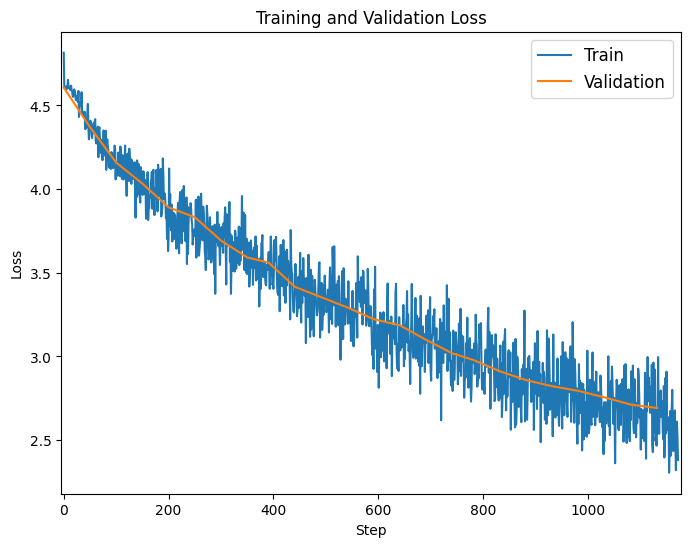

In [45]:
# train_x = np.arange(EPOCHS*len(train_loader))
# # have to account for smaller last batch per epoch
# val_x = np.concatenate([np.arange(len(train_loader), step=50),
#                  len(train_loader) + np.arange(len(train_loader), step=50),
#                  2*len(train_loader) + np.arange(len(train_loader), step=50)])

# fig, ax = plt.subplots(figsize=(8,6))
# ax.plot(train_x, train_losses, label="Train")
# ax.plot(val_x, val_losses, label="Validation")
# plt.xlabel("Step")
# plt.ylabel("Loss")
# plt.title("Training and Validation Loss")
# plt.xlim(-5, len(train_loader)*3 + 5)
# plt.legend(fontsize='large')
# plt.show()

### Part 2) Validation accuracy across the pruned model checkpoints

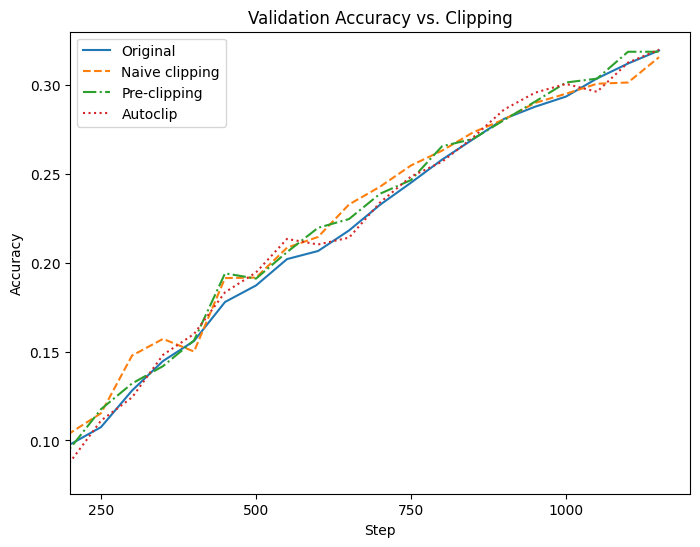

In [174]:
# plt.figure(figsize=(8, 6))
# plt.title("Validation Accuracy vs. Clipping")
# plt.plot(val_accuracies, '-', label="Original")
# plt.plot(val_accuracies_hc, '--', label="Naive clipping")
# plt.plot(val_accuracies_pc, '-.', label="Pre-clipping")
# plt.plot(val_accuracies_ac, ':', label="Autoclip")
# plt.xlabel("Step")
# plt.ylabel("Accuracy")
# plt.xticks(
#     ticks=plt.xticks()[0][1:], labels=50 * np.array(plt.xticks()[0][1:], dtype=int)
# )  # steps * 50
# plt.legend()

# plt.axis([4, 24, 0.07, 0.33]) # ZOOM IN, plt.axis([x_min, x_max, y_min, y_max])
# # # note it does not use the updated tick numbers ofc

# plt.show()